In [1]:
from scipy import misc
from skimage import measure
from geometry import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#img1 = misc.imread('./ampulla_(3-1to3-5_L2-3_tr-amp).png')
img = misc.imread('./ampulla_(3-1to3-5_L2-3_tr-amp)_2.png')

From the loaded image, select the pixels with no transparency and having the foreground color close to white.

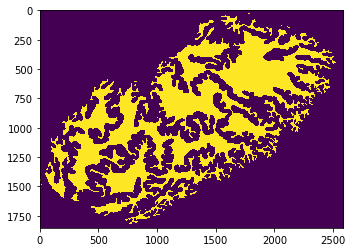

In [3]:
# extract the area where the EVs will interact
#foreground1 = (img1[:,:,3] != 0) & (img1[:,:,1] > 240)
foreground = (img[:,:,3] != 0) & (img[:,:,1] > 240)
#plt.imshow(foreground1)
plt.imshow(foreground)

To identify our areas of interest, we use `scikit image` to find the contours of the previously selected foreground.  

Then, from the identified contours, we find and display those having more than 210 vertices. These will be further processed in the following steps.

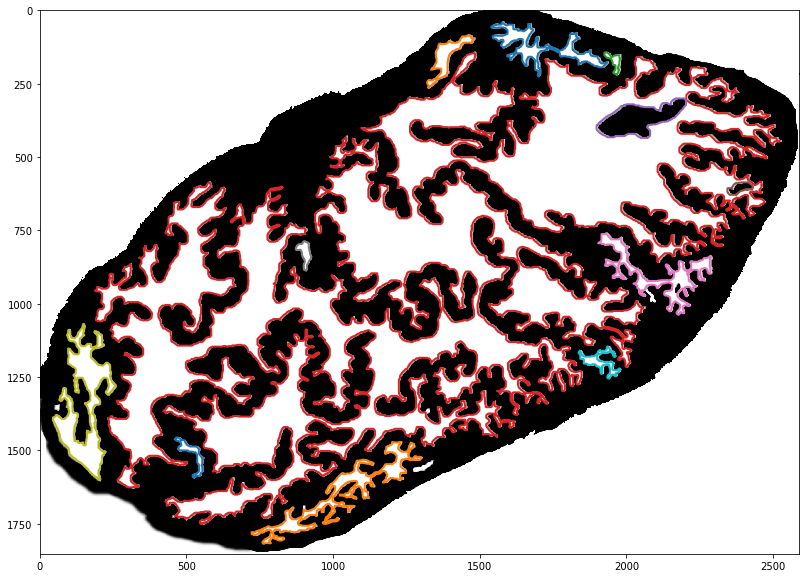

In [4]:
#contours1 = measure.find_contours(foreground1, 0.8)
contours = measure.find_contours(foreground, 0.8)

# create two side-by-side plots
fig, (ax) = plt.subplots(1, 1, sharex='col', figsize=(20,10))
# show first image
#ax1.imshow(img1, interpolation = 'nearest', cmap = plt.cm.gray)

#for n, contour in enumerate(contours1):
    #ax1.plot(contour[:, 1], contour[:, 0], linewidth=2)

gtN = []

# show second image
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    if(len(contour) > 210):
        gtN.append(n)
        ax.plot(contour[:,1], contour[:,0], linewidth=2)

plt.show()

In [5]:
# how many contours were found?, how many of them have more than N edges, and what are those?
len(contours), len(gtN), gtN

(75, 12, [2, 3, 9, 11, 12, 14, 20, 21, 29, 37, 51, 58])

## Selective contour plotting (optional)  
We can use the code in the following cell to selectively plot the identified contours

[0, 2588, 1853, 0]

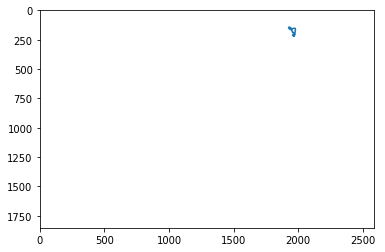

In [6]:
n = 2
plt.plot(contours2[gtN[n]][:,1], contours2[gtN[n]][:,0])
plt.axis([0, 2588, 1853, 0])

## Nested contours  (To use as emmiting surfaces)

Two of the identified contours (#12 & #14) are located within a larger contour (#11). These are shown here, but must be subtracted prior to executing the simulation.

[0, 2588, 1853, 0]

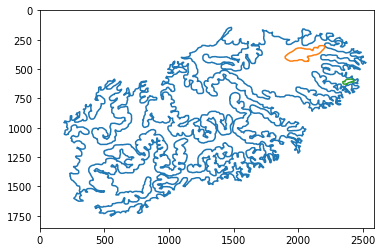

In [7]:
# contours 12 & 14 lay within countour 11
plt.plot(contours2[gtN[3]][:,1], contours2[gtN[3]][:,0])
plt.plot(contours2[gtN[4]][:,1], contours2[gtN[4]][:,0])
plt.plot(contours2[gtN[5]][:,1], contours2[gtN[5]][:,0])
plt.axis([0, 2588, 1853, 0])

## EV potential starting point coordinates

Given that the extra cellular vesicles are being produced by the oviductal walls, the vertices for the identified contours will provide the initial vesicle coordinates.

To simplify spatial analytics we use the [`shapely`](https://github.com/Toblerity/Shapely) package.

~~`borders`~~`allVertices` will be the global storage for the polygon's external vertices identified    
`startingCoords[{Points:Normals}]` will store the 3d coordinates for the point and normal of the source of the EVs being generated. These will be computed from the vertices using the following algorithm:  
```
foreach vertex in polygon:
    p1 = Point3D(vertex.x, vertex.y, 0)
    p2 = Point3D(next_vertex.x, next_vertex.y, 0)
    p = Point3D((p1.x + p2.x)/2, (p1.y - p2.y)/2, 0)
    normal = Plane(p1, p2, p).normal_vector
    [p, normal]
```
The collection of vertices for each border will be used to estimate the candidate coordinates where the EVs will be produced from. These will be taken from the middle point between each pair of vertices on the polygon. 

**TODO** The number of extra points between the vertices must be related to the euclidean distance between the edges

In [8]:
def identifySourcePoints(vertices, useInternalNormal=True):
    sourcePoints = []
    # traverse the vertices on the contour
    n = len(vertices)
    for i in range(n-1):
        p1 = (vertices[i][0], vertices[i][1])
        p2 = (vertices[i+1][0], vertices[i+1][1])

        sourcePoints.append({'p': middlePoint(p1, p2), 'normal': unitVector2p(twoPointsNormal(p1, p2, useInternalNormal))})
    return sourcePoints

To simplify the polygons we work with, we call the function `approximate_polygon` implementing the [Douglas-Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).

In [15]:
allVertices = []
startingCoords = []
simplify = True
tolerance = 0.25

# manually store the first polygons identified
for i in range(len(gtN)):
    if simplify:
        #  ()
        vertices = measure.approximate_polygon(contours[gtN[i]], tolerance)
    else:
        vertices = contours2[gtN[i]]

    # add this to the global vertices storage
    allVertices.append(vertices)
    # As previously stated, contours 12 & 14 lay within countour 11, their normals must point in the other direction
    if i > 3 and i < 6:
        sourcePoints = identifySourcePoints(vertices, False)
    else:
        sourcePoints = identifySourcePoints(vertices)
    
    startingCoords.append(sourcePoints)

scs = len(startingCoords)
#print(startingCoords)
for i in range(scs):
    print('figure:',i, 'n.s.coords:',len(startingCoords[i]))

figure: 0 n.s.coords: 429
figure: 1 n.s.coords: 111
figure: 2 n.s.coords: 76
figure: 3 n.s.coords: 11447
figure: 4 n.s.coords: 135
figure: 5 n.s.coords: 66
figure: 6 n.s.coords: 704
figure: 7 n.s.coords: 112
figure: 8 n.s.coords: 651
figure: 9 n.s.coords: 211
figure: 10 n.s.coords: 150
figure: 11 n.s.coords: 1060


We can present a visualization of the computed sources of EVs and their normals 

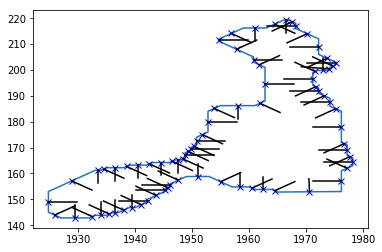

In [19]:
i = 2
target_polygon = allVertices[i]
plt.plot(allVertices[i][:,1],allVertices[i][:,0])
for sc in startingCoords[i]:
    #print(sc)
    #break
    plt.plot(sc['p'][1], sc['p'][0], 'bx')
    pn = pointOverNormal(sc['p'], sc['normal'], 5)
    plt.plot([sc['p'][1], pn[1]], [sc['p'][0], pn[0]], 'k-')
    #break

## Simulating EVs production
Based on the identified coordinates for the source of origin of the EVs, we proceed to link the simulation

In [21]:
target_polygon

(77, 2)

In [ ]:
n = 2
interval = 1
len(contours2[gtN[n]])
vertex = contours2[gtN[n]]

In [ ]:
gt = 0
for i in range(len(vertex)):
    p1 = Point3D(vertex[i][0], vertex[i][1], 0)
    if(i+interval < len(vertex)):
        p2 = Point3D(vertex[i+interval][0], vertex[i+interval][1], 0)
    else:
        p2 = Point3D(vertex[0][0], vertex[0][1], 0)
    if p1.distance(p2) > 2:
        gt += 1
        #p3 = Point3D((vertex[i][0] + vertex[i+interval][0])/2, (vertex[i][1] + vertex[i+interval][1])/2, 1)
        #pl = Plane(p1, p2, p3)
gt

In [14]:
help(geometry)

Help on module geometry:

NAME
    geometry

FUNCTIONS
    middlePoint(point1, point2)
    
    pointOverNormal(point, normal, scale=1.0)
    
    twoPointsNormal(point1, point2, left=True)
    
    unitVector2p(vector)

FILE
    d:\development\python\scripts\geometry.py




In [13]:
import geometry

In [22]:
429+ 111+ 76+ 11447+ 135+ 66+ 704+ 112+ 651+ 211+ 150+ 1060

15152

## Algorithm  

### Source point allocation  
I will need to define S sections (S=12 in this example)
The number of vesicles produced per section will be proportionally distributed according to the lengh of the perimeter of the section. (TotalEVs / nEdges) * sectionEdges  

Each edge has its normal computed.  

Then, each EV's source point will be randomly assigned from a uniform distribution over the section edges. The initial direction for each EV will be the normal to the edge.  

### Boundary rendering  
I should add the following environment parameters to the model
numberOfSections = 12  (for this example)
edgesPerSection = [429, 111, 76, 11447, 135, 66, 704, 112, 651, 211, 150, 1060, 0, 0, 0] (perhaps max lenght 50)
*Note: The edges need to be defined outside the model?*
edges = [15152]


### Boundary collision detection

